In [19]:
import nengo
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from simplified_stdp import STDP
import tensorflow as tf
import os
from nengo.dists import Choice
from datetime import datetime
from nengo_extras.data import load_mnist
import pickle
plt.rcParams.update({'figure.max_open_warning': 0})

from nengo.utils.matplotlib import rasterplot


import numpy as np

import nengo.utils.numpy as npext
from nengo.base import Process
from nengo.dists import DistributionParam, Gaussian
from nengo.exceptions import ValidationError
from nengo.params import (
    BoolParam, DictParam, EnumParam, NdarrayParam, NumberParam)
from nengo.synapses import LinearFilter, Lowpass, SynapseParam


In [10]:
#############################
# load the data
#############################

img_rows, img_cols = 28, 28
input_nbr = 100

(image_train, label_train), (image_test, label_test) = (tf.keras.datasets.mnist.load_data())

#select the 0s and 1s as the two classes from MNIST data
image_train_filtered = []
label_train_filtered = []

# x = 3
# for i in range(0,input_nbr):
#   if label_train[i] == x:
#         image_train_filtered.append(image_train[i])
#         label_train_filtered.append(label_train[i])
#         if x == 3:
#             x = 2
#         else:
#             x = 3

for i in range(0,input_nbr):
    image_train_filtered.append(image_train[i])
    label_train_filtered.append(label_train[i])

image_train_filtered = np.array(image_train_filtered)
label_train_filtered = np.array(label_train_filtered)

In [31]:
#############################
# Helpfull methodes
#############################

def sparsity_measure(vector):  # Gini index
    # Max sparsity = 1 (single 1 in the vector)
    v = np.sort(np.abs(vector))
    n = v.shape[0]
    k = np.arange(n) + 1
    l1norm = np.sum(v)
    summation = np.sum((v / l1norm) * ((n - k + 0.5) / n))
    return 1 - 2 * summation

def HeatMapSave(network,name,probe,samples=1,neuron=1):
    x = int(samples/100)

    if not os.path.exists(name):
        os.makedirs(name)

    plt.matshow(np.reshape(network.data[probe][:,neuron][samples-1],(28,28)))
    plt.title(samples-1)
    plt.savefig(name+"/"+str(neuron)+":"+str(samples-1)+".png")
    plt.cla()
    
    
class PresentInput(nengo.Process):
    """Present a series of inputs, each for the same fixed length of time.

    Parameters
    ----------
    inputs : array_like
        Inputs to present, where each row is an input. Rows will be flattened.
    presentation_time : float
        Show each input for this amount of time (in seconds).
    """

    inputs = NdarrayParam('inputs', shape=('...',))
    presentation_time = NumberParam('presentation_time', low=0, low_open=True)

    def __init__(self, inputs, presentation_time, **kwargs):
        self.inputs = inputs
        self.presentation_time = presentation_time
        super(PresentInput, self).__init__(
            default_size_in=0, default_size_out=self.inputs[0].size, **kwargs)

    def make_step(self, shape_in, shape_out, dt, rng):
        assert shape_in == (0,)
        assert shape_out == (self.inputs[0].size,)

        n = len(self.inputs)
        inputs = self.inputs.reshape(n, -1)
        presentation_time = float(self.presentation_time)

        def step_presentinput(t):
            pause_time = 100/1000
            i = int((t-dt) / (presentation_time-pause_time) + 1e-7)
            return inputs[i % n]

        return step_presentinput

In [36]:
model = nengo.Network("My network")
#############################
# Model construction
#############################

presentation_time = 0.20 #0.35
#input layer

n_in = 784
n_neurons = 10

with model:

    # input layer 
    picture = nengo.Node(nengo.processes.PresentInput(image_train_filtered, presentation_time))
    true_label = nengo.Node(nengo.processes.PresentInput(label_train_filtered, presentation_time))
    
    input_layer = nengo.Ensemble(
        784,
        1,
        label="input",
        max_rates=nengo.dists.Uniform(22, 22),
        intercepts=nengo.dists.Choice([0]),
        )
    input_conn = nengo.Connection(picture,input_layer.neurons,synapse=None)

    # weights randomly initiated 
    layer1_weights = random.random((n_neurons, n_in))
   
    #Noise 
    process = nengo.processes.WhiteNoise(dist=nengo.dists.Gaussian(0, 22), seed=5)

    # define first layer
    layer1 = nengo.Ensemble(
         n_neurons,
         1,
         neuron_type=nengo.neurons.AdaptiveLIF(tau_rc=0.1),
#          max_rates=nengo.dists.Uniform(500, 500),
         intercepts=nengo.dists.Choice([0]),
#          encoders = nengo.dists.Uniform(0,1), 
         label="layer1",
        noise=process,
         max_rates=nengo.dists.Uniform(250,499),
#          intercepts=nengo.dists.Choice([0])
         )

    # define connection between the two layers
    conn1 = nengo.Connection(
        input_layer.neurons,
        layer1.neurons,
        synapse=None,
        transform = layer1_weights,
#         learning_rule_type = [nengo.BCM(learning_rate=5e-10),nengo.Oja(learning_rate=2e-9)]
        learning_rule_type=STDP(
            alf_p=0.005,
            alf_n=0.01,
            beta_p=1.5,
            beta_n=2.5,
            bounds='soft',
            max_weight=1,
            min_weight=0.1*0.1
        )
        )

#     create inhibitory layer 
#     layer1_inh = nengo.Ensemble(
#          n_neurons,
#          1,
#          neuron_type=nengo.neurons.LIF(),
#         gain = nengo.dists.Uniform(2,2), 
#          bias = nengo.dists.Uniform(0,0), 
#          encoders = nengo.dists.Uniform(1,1), 
#          label="layer1",
#          max_rates=nengo.dists.Uniform(20,50),
#          intercepts=nengo.dists.Choice([0])
#          )
    
#     exc_inh_wegihts = np.eye(n_neurons)*5
#     inh_exc_wegihts = (np.full((n_neurons, n_neurons), 1) - np.eye(n_neurons)) * 5
    
#     conn_exc_inh = nengo.Connection(layer1.neurons, layer1_inh.neurons, transform=exc_inh_wegihts)
#     conn_inh_exc = nengo.Connection(layer1_inh.neurons, layer1.neurons, transform=inh_exc_wegihts)
    
    
    inhib_wegihts = (np.full((n_neurons, n_neurons), 1) - np.eye(n_neurons)) * -100

    inhib = nengo.Connection(layer1.neurons, layer1.neurons, transform=inhib_wegihts)
        
    #############################

    #############################
    # setup the probes
    #############################

    connection_layer1_probe = nengo.Probe(conn1,"weights",label="layer1_synapses") 
    
    p_true_label = nengo.Probe(true_label)
    p_layer_1 = nengo.Probe(layer1.neurons)

with nengo.Simulator(model) as sim:
    sim.run((presentation_time) * label_train_filtered.shape[0])

#save the model
pickle.dump(sim.data[connection_layer1_probe][-1], open( "mnist_params_STDP", "wb" ))

now = str(datetime.now().time())
folder = "My Sim "+now

for i in range(0,(n_neurons)):
   HeatMapSave(sim,folder,connection_layer1_probe,sim.data[connection_layer1_probe].shape[0],i)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

KeyboardInterrupt: 

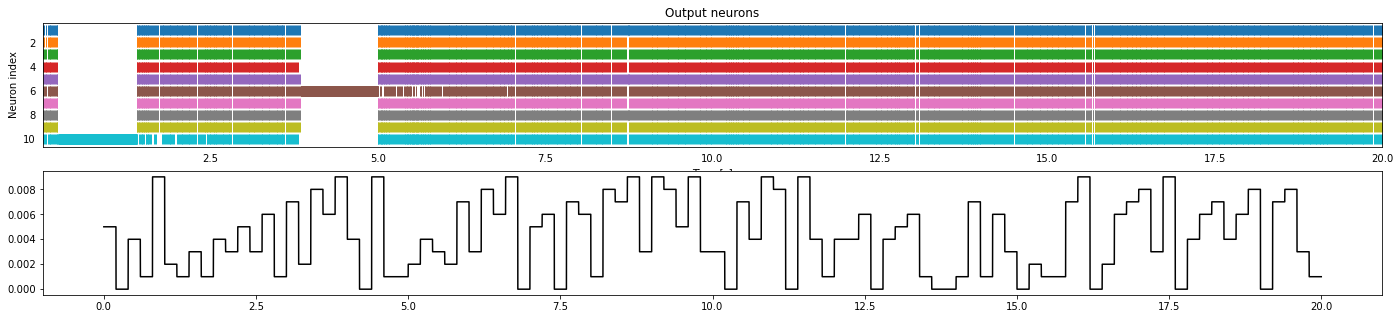

In [13]:
plt.figure(figsize=(24,5))
plt.subplot(2,1,1)
plt.title('Output neurons')
rasterplot(sim.trange(), sim.data[p_layer_1])
plt.xlabel("Time [s]")
plt.ylabel("Neuron index")
plt.subplot(2,1,2)
plt.plot(sim.trange(), sim.data[p_true_label]/1000, c='k', label='spikes')